# Chapter 1

https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_TFP.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tf_helpers import *

/Users/spencer/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.13.1

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Setup tf eager: True


In [3]:
t = tf.reduce_sum(tf.random_normal([1000, 1000]))
t, t.numpy(), eval_tensor(t)

(<tf.Tensor: id=7, shape=(), dtype=float32, numpy=-1385.1799>,
 -1385.1799,
 -1385.1799)

# Coin Flip Example

In [4]:
prior = tfp.distributions.Bernoulli(probs=0.5, dtype=tf.int32)

num_trials = tf.constant([0,1, 2, 3, 4, 5, 8, 15, 50, 500, 1000, 2000])
num_trials

<tf.Tensor: id=17, shape=(12,), dtype=int32, numpy=
array([   0,    1,    2,    3,    4,    5,    8,   15,   50,  500, 1000,
       2000], dtype=int32)>

In [5]:
# Get headcounts in each trial
data = prior.sample(num_trials[-1])

# prepend a 0 onto tally of heads and tails, for zeroth flip
print(data.numpy())
data = tf.pad(data, tf.constant([[1, 0,]]), 'CONSTANT')
print(data.numpy())

# Get cumulative counts and slice at each number of trials
heads = tf.gather(tf.cumsum(data), num_trials)
print(heads.numpy())

# Updated probabilities
observed_dist = tfp.distributions.Beta(
    concentration1=tf.cast(1 + heads, tf.float32),
    concentration0=tf.cast(1 + num_trials - heads, tf.float32)
)

prob_rng = tf.linspace(start=0., stop=1., num=100, name='linspace')
observed_probs_heads = tf.transpose(observed_dist.prob(prob_rng[:, tf.newaxis]))
observed_probs_heads.numpy()

[0 1 1 ... 1 0 0]
[0 0 1 ... 1 0 0]
[  0   0   1   2   2   3   4   9  26 256 505 976]


array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
               nan],
       [2.        , 1.979798  , 1.9595959 , ..., 0.04040409, 0.02020204,
        0.        ],
       [0.        , 0.05999387, 0.11876338, ..., 0.11876352, 0.05999393,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

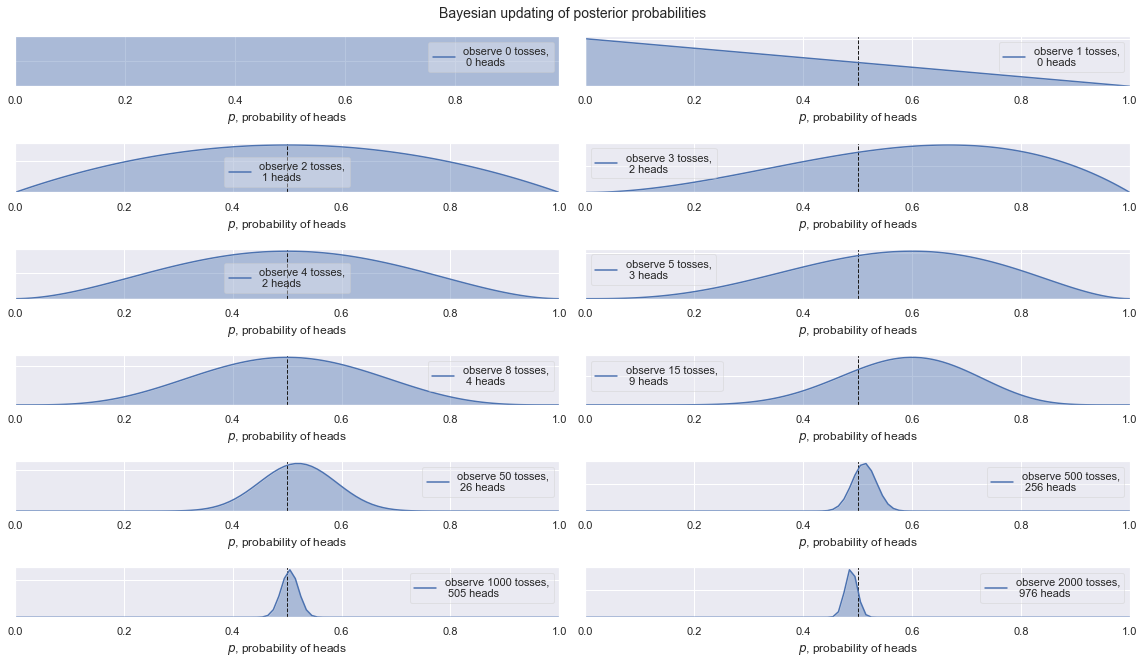

In [6]:
# For the already prepared, I'm using Binomial's conj. prior.
plt.figure(figsize=(16, 9))
for i in range(len(num_trials.numpy())):
    sx = plt.subplot(len(num_trials.numpy())/2, 2, i+1)
    plt.xlabel("$p$, probability of heads")
    plt.setp(sx.get_yticklabels(), visible=False)
    plt.plot(prob_rng.numpy(),
             observed_probs_heads.numpy()[i], 
             label="observe %d tosses,\n %d heads" % (num_trials.numpy()[i], heads.numpy()[i]))
    plt.fill_between(prob_rng.numpy(), 0, observed_probs_heads.numpy()[i], alpha=0.4)
    plt.vlines(0.5, 0, observed_probs_heads.numpy()[i].max()*1.05, color="k", linestyles="--", lw=1)
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities", y=1.02,
             fontsize=14)
plt.tight_layout()

# Prior

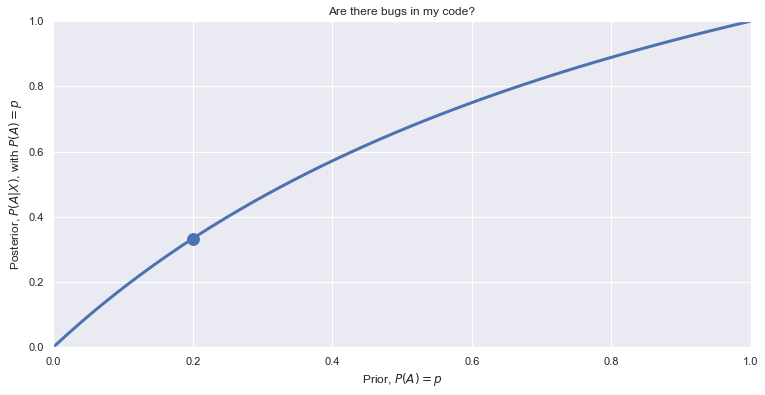

In [7]:
# Defining our range of probabilities
p = np.linspace(start=0., stop=1., num=50)

# Visualization.
plt.figure(figsize=(12.5, 6))
plt.plot(p, 2*p/(1+p), lw=3)
plt.scatter(0.2, 2*(0.2)/1.2, s=140)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r"Prior, $P(A) = p$")
plt.ylabel(r"Posterior, $P(A|X)$, with $P(A) = p$")
plt.title(r"Are there bugs in my code?");

# SMS

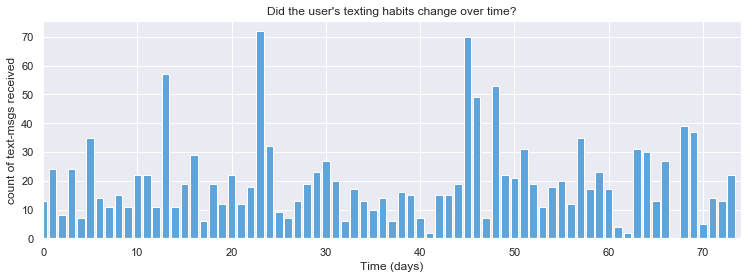

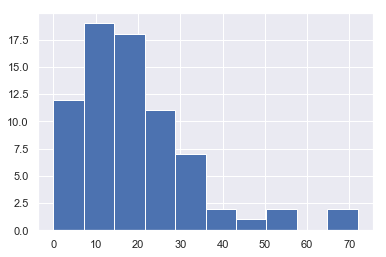

In [8]:
# Defining our Data and assumptions
cnts = np.array([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
])
days = np.arange(len(cnts))

plt.figure(figsize=(12.5, 4))
plt.bar(days, cnts, color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, len(cnts))

plt.subplots()
plt.hist(cnts);

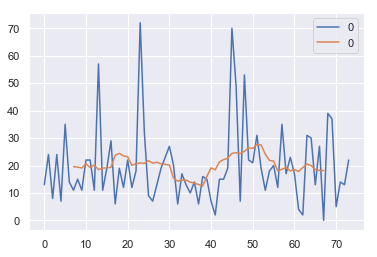

In [9]:
import pandas as pd
df = pd.DataFrame(data=cnts)
ax = df.plot()
df.rolling(14, center=True).mean().plot(ax=ax)

In [10]:
tfd = tfp.distributions

def joint_log_prob(lambda_1, lambda_2, tau):
    
    # Alpha is mean of cnts
    alpha = np.array(1. / cnts.mean(), np.float32)

    # Keep lambdas of poisons as random vars
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
 
    # Location for change in lambda
    rv_tau = tfd.Uniform(high=cnts.size)
 
    lambda_idx = tau <= np.arange(cnts.size)
    lambda_ = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.cast(lambda_idx, tf.int32))
    rv_observation = tfd.Poisson(rate=lambda_)
 
    # Combined probibility of all the observations (inputs)
    return (
         rv_lambda_1.log_prob(lambda_1)
         + rv_lambda_2.log_prob(lambda_2)
         + rv_tau.log_prob(tau)
         + tf.reduce_sum(rv_observation.log_prob(cnts))
    )

# Initial states
mean_cnt = cnts.mean()
initial_chain_state = [
    tf.convert_to_tensor(mean_cnt, dtype=tf.float32, name="init_lambda1"),
    tf.convert_to_tensor(mean_cnt, dtype=tf.float32, name="init_lambda2"),
    tf.convert_to_tensor(0.5, dtype=tf.float32, name="init_tau"),
]
print('Init vals', eval_tensor(initial_chain_state))

# Mapping vars to real space
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]

# Initialize the step_size. (It will be automatically adapted.)
# TODO what is going on here
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.05, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

Init vals [19.743244, 19.743244, 0.5]


In [33]:
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=joint_log_prob,
    num_leapfrog_steps=2,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(None),
    state_gradients_are_stopped=True,
)
    
# To apply bijector
kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=kernel,
        bijector=unconstraining_bijectors,
)
    
# Monte Carlo Markov Chain
posteriers, kernel_results = tfp.mcmc.sample_chain(
    num_results=10000,
    num_burnin_steps=1000,
    current_state=initial_chain_state,
    kernel=kernel,
    parallel_iterations=10,
)

In [34]:
lambda_1_samples, lambda_2_samples, posterior_tau = posteriers

# Possible time change locations
tau_samples = tf.floor(posterior_tau * tf.to_float(tf.size(cnts)))

# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tf.shape(tau_samples)[0]
expected_texts_per_day = tf.zeros(len(cnts))

# Initialize any created variables.
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

In [35]:
eval_tensor(init_g)
eval_tensor(init_l)
[
    lambda_1_samples_,
    lambda_2_samples_,
    tau_samples_,
    kernel_results_,
    N_,
    expected_texts_per_day_,
] = eval_tensor([
    lambda_1_samples,
    lambda_2_samples,
    tau_samples,
    kernel_results,
    N,
    expected_texts_per_day,
])

    
print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.6363
final step size: 0.046878572553396225


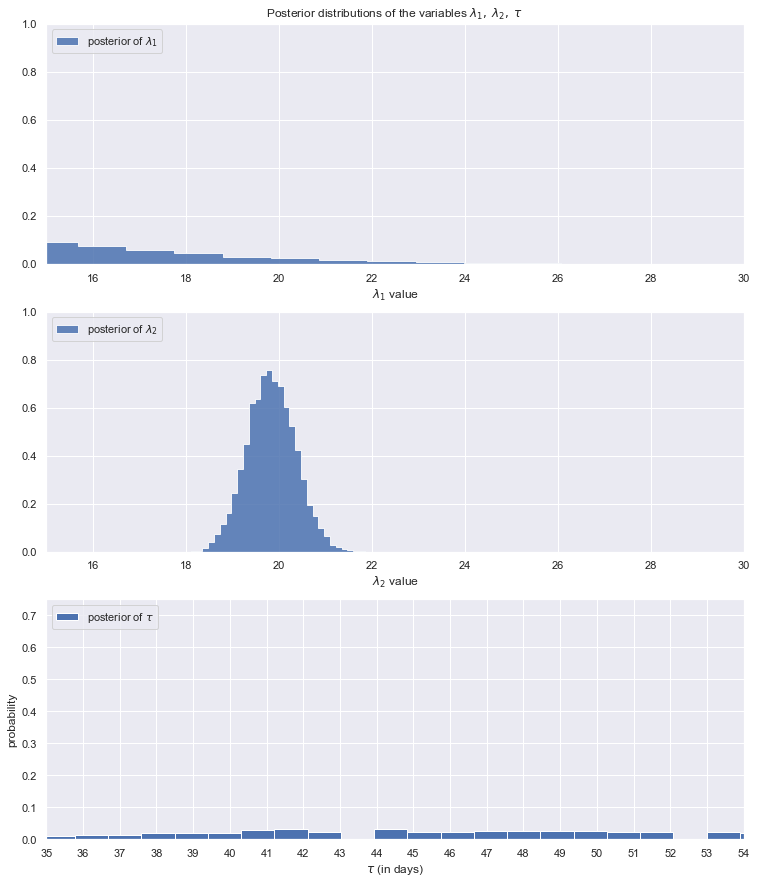

In [36]:
plt.figure(figsize=(12.5, 15))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples_, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_1$", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel(r"$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples_, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_2$", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel(r"$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples_.shape[0] * np.ones_like(tau_samples_)
plt.hist(tau_samples_, bins=len(cnts), alpha=1,
         label=r"posterior of $\tau$", weights=w, rwidth=2.)
plt.xticks(np.arange(len(cnts)))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(cnts)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel(r"probability");

In [25]:
exp = tfp.bijectors.Exp()
x = [[[1., 2],
       [3, 4]],
      [[5, 6],
       [7, 8]]]
np.allclose(np.exp(x), exp.forward(x)), np.allclose(np.log(x), exp.inverse(x))

(True, True)

In [39]:
lambda_1_samples_.mean(), lambda_2_samples_.mean()

(13.628317, 19.832285)